In [19]:
import pandas as pd
import pandasql as psq # conda install -c anaconda pandasql 
import duckdb # pip install duckdb
from pandas_profiling import ProfileReport # pip install -U pandas-profiling[notebook]==3.2.0 markupsafe==2.0.1
import numpy as np
from patsy import dmatrices
from sklearn import preprocessing

from statsmodels.compat import lzip
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.rc("figure", figsize=(16, 8))
plt.rc("font", size=14)


In [95]:
df = pd.read_csv ('../data/cleaned_online_retail.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406829 entries, 0 to 406828
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   406829 non-null  int64  
 1   invoiceno    406829 non-null  object 
 2   stockcode    406829 non-null  object 
 3   description  406829 non-null  object 
 4   quantity     406829 non-null  int64  
 5   invoicedate  406829 non-null  object 
 6   unitprice    406829 non-null  float64
 7   customerid   406829 non-null  float64
 8   country      406829 non-null  object 
dtypes: float64(2), int64(2), object(5)
memory usage: 27.9+ MB


In [96]:
print(df.columns)

Index(['Unnamed: 0', 'invoiceno', 'stockcode', 'description', 'quantity',
       'invoicedate', 'unitprice', 'customerid', 'country'],
      dtype='object')


In [97]:
#Dropping unnecessary columns
if 'Unnamed: 0' in list(df.columns):
    df.drop(['Unnamed: 0'], axis=1, inplace=True)
#rename specific column names
df.rename(columns = {'description':'product'}, inplace = True)
# column type change
df['customerid'] = df['customerid'].astype(int).astype(str)
print(df.columns)

Index(['invoiceno', 'stockcode', 'product', 'quantity', 'invoicedate',
       'unitprice', 'customerid', 'country'],
      dtype='object')


In [98]:
#Extracting year and month from invoicedate
df['year'] = pd.DatetimeIndex(df['invoicedate']).year
df['month'] = pd.DatetimeIndex(df['invoicedate']).month
df.drop('invoicedate', inplace=True, axis=1)

# total sales
df['total_sale'] = df['quantity']*df['unitprice']

# year_month
df['year_month'] = df['year'].astype(str)+'-'+df['month'].astype(str).str.zfill(2)

In [99]:
df.head()

,invoiceno,stockcode,product,quantity,unitprice,customerid,country,year,month,total_sale,year_month
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850,United Kingdom,2010,12,15.30,2010-12
1,536365,71053,WHITE METAL LANTERN,6,3.39,17850,United Kingdom,2010,12,20.34,2010-12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850,United Kingdom,2010,12,22.00,2010-12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850,United Kingdom,2010,12,20.34,2010-12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850,United Kingdom,2010,12,20.34,2010-12


In [100]:
categorical_features = ['stockcode', 'product', 'country']
le_product = preprocessing.LabelEncoder()
le_country = preprocessing.LabelEncoder()

for column in categorical_features:
    if column == 'product':
        le_product.fit(list(df[column]))
        df[column] = le_product.transform(list(df[column]))
        df[column] = df[column].astype('category')
    elif column == 'country':
        le_country.fit(list(df[column]))
        df[column] = le_country.transform(list(df[column]))
        df[column] = df[column].astype('category')
    else: 
        df[column] = df[column].astype('category').cat.codes

In [143]:
print(le_product.classes_, len(le_product.classes_)) # get the class names of product

product_classes = le_product.classes_
product_classes = {i: product_classes[i] for i in range(len(le_product.classes_))}

[' 4 PURPLE FLOCK DINNER CANDLES' " 50'S CHRISTMAS GIFT BAG LARGE"
 ' DOLLY GIRL BEAKER' ... 'ZINC WILLIE WINKIE  CANDLE STICK'
 'ZINC WIRE KITCHEN ORGANISER' 'ZINC WIRE SWEETHEART LETTER TRAY'] 3896


In [102]:
df

,invoiceno,stockcode,product,quantity,unitprice,customerid,country,year,month,total_sale,year_month
0,536365,3249,3716,6,2.55,17850,35,2010,12,15.30,2010-12
1,536365,2649,3724,6,3.39,17850,35,2010,12,20.34,2010-12
2,536365,2855,861,8,2.75,17850,35,2010,12,22.00,2010-12
3,536365,2803,1813,6,3.39,17850,35,2010,12,20.34,2010-12
4,536365,2802,2776,6,3.39,17850,35,2010,12,20.34,2010-12
...,...,...,...,...,...,...,...,...,...,...,...
406824,581587,1470,2263,12,0.85,12680,13,2011,12,10.20,2011-12
406825,581587,1746,695,6,2.10,12680,13,2011,12,12.60,2011-12
406826,581587,2086,701,4,4.15,12680,13,2011,12,16.60,2011-12
406827,581587,2087,700,4,4.15,12680,13,2011,12,16.60,2011-12


In [ ]:
#  could not run because of memory issue

# profile = ProfileReport(df, title="Report")
# profile.to_notebook_iframe()

We can see that there is no such correlation in any features

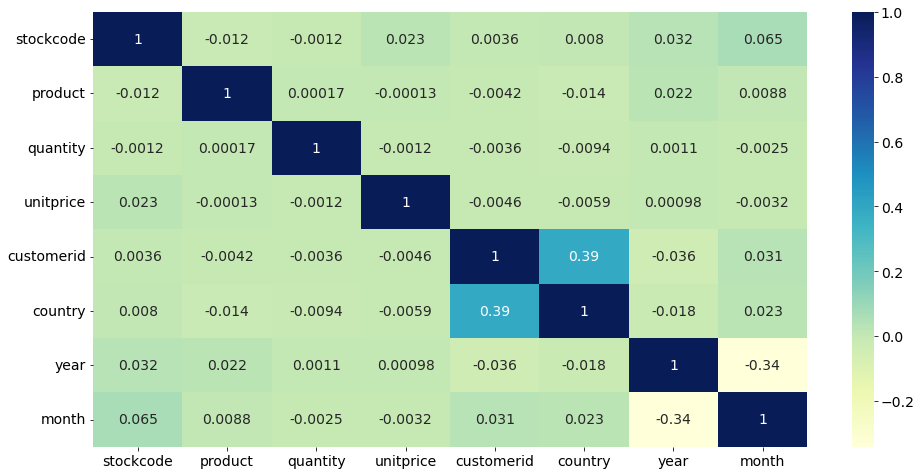

In [38]:
# without changing df
corr = df.corr().round(3)
dataplot = sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)
  
# displaying heatmap
plt.show()

In [103]:
df[df['invoiceno']=='536365'] 

,invoiceno,stockcode,product,quantity,unitprice,customerid,country,year,month,total_sale,year_month
0,536365,3249,3716,6,2.55,17850,35,2010,12,15.30,2010-12
1,536365,2649,3724,6,3.39,17850,35,2010,12,20.34,2010-12
2,536365,2855,861,8,2.75,17850,35,2010,12,22.00,2010-12
3,536365,2803,1813,6,3.39,17850,35,2010,12,20.34,2010-12
4,536365,2802,2776,6,3.39,17850,35,2010,12,20.34,2010-12
5,536365,1605,2977,2,7.65,17850,35,2010,12,15.30,2010-12
6,536365,755,1444,6,4.25,17850,35,2010,12,25.50,2010-12


data has some negative quantity, so there is a question: what does it mean??? will we remove it??

In [174]:
df[df['quantity']<0]

,invoiceno,stockcode,product,quantity,unitprice,customerid,country,year,month,total_sale,year_month
141,C536379,3679,1066,-1,27.50,14527,35,2010,12,-27.50,2010-12
154,C536383,2407,3016,-1,4.65,15311,35,2010,12,-4.65,2010-12
235,C536391,1415,2581,-12,1.65,17548,35,2010,12,-19.80,2010-12
236,C536391,919,2247,-24,0.29,17548,35,2010,12,-6.96,2010-12
237,C536391,918,2238,-24,0.29,17548,35,2010,12,-6.96,2010-12
...,...,...,...,...,...,...,...,...,...,...,...
406377,C581490,1979,3891,-11,0.83,14397,35,2011,12,-9.13,2011-12
406461,C581499,3681,2140,-1,224.69,15498,35,2011,12,-224.69,2011-12
406635,C581568,454,3551,-5,10.95,15311,35,2011,12,-54.75,2011-12
406636,C581569,3131,1576,-1,1.25,17315,35,2011,12,-1.25,2011-12


Below, it has been demonstrated that the product's price is varied time to time

In [105]:
product0 = df[df['product']==0].sort_values(by=['year_month'])
product0

,invoiceno,stockcode,product,quantity,unitprice,customerid,country,year,month,total_sale,year_month
1056,536522,2692,0,2,2.55,15012,35,2010,12,5.10,2010-12
5236,537044,2692,0,12,2.55,18055,35,2010,12,30.60,2010-12
28581,540247,2692,0,1,2.55,15464,35,2011,1,2.55,2011-01
44399,542226,2692,0,1,2.55,17075,35,2011,1,2.55,2011-01
68887,545186,2692,0,1,2.55,17841,35,2011,2,2.55,2011-02
97622,548642,2692,0,3,2.55,17287,35,2011,4,7.65,2011-04
99532,548808,2692,0,3,2.55,17774,35,2011,4,7.65,2011-04
112392,550459,2692,0,1,2.55,18116,35,2011,4,2.55,2011-04
112403,550459,2692,0,1,2.55,18116,35,2011,4,2.55,2011-04
144546,554506,2692,0,2,2.55,14083,35,2011,5,5.10,2011-05


In [119]:
# which products are sold most in numbers of sales (means how much money the product gains)
# and in number of per invoice (means the number of customer choose the product in his order) 
# and in number of quantity (means how maany this product has been sold)
# within 2010-2011?

product_quantity = duckdb.query("""
select product, sum(total_sale) as total_sale, count(invoiceno) as total_invoice, sum(quantity) as total_quantity 
from df group by product order by total_sale DESC
""").df()
product_quantity

,product,total_sale,total_invoice,total_quantity
0,2780,132870.40,1905,11555.0
1,3716,93823.85,2070,34147.0
2,1771,83236.76,1662,45066.0
3,2355,67687.53,1416,15027.0
4,2624,66710.24,1196,3002.0
...,...,...,...,...
3891,3702,-54.00,1,-8.0
3892,660,-87.80,5,-4.0
3893,1066,-5696.22,77,-1194.0
3894,882,-7933.43,16,-16.0


In [126]:
top_5_products_in_2010_2011 = list(product_quantity['product'].head(5))
top_5_products_in_2010_2011

[2780, 3716, 1771, 2355, 2624]

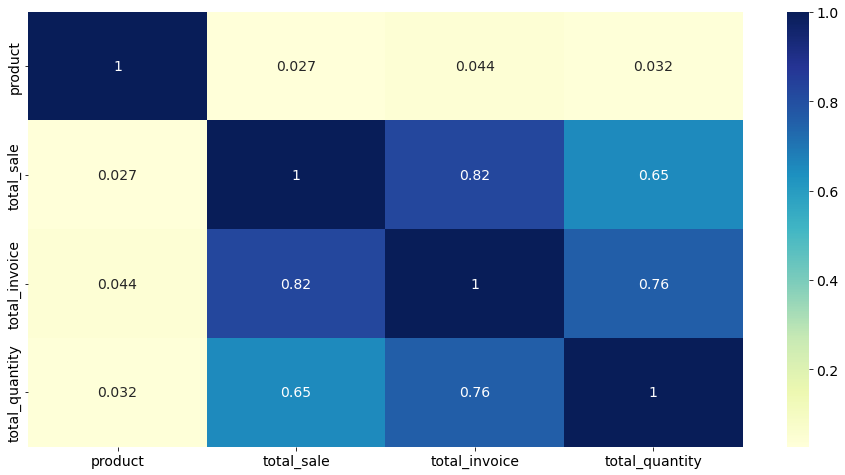

In [124]:
corr = df.corr().round(3)
dataplot = sns.heatmap(product_quantity.corr(), cmap="YlGnBu", annot=True)

In [122]:
# get the product information of total sales and their unit price varies within year_month

product_infos = duckdb.query("""
select q1.*, q2.unitprice from 
(select distinct unitprice, year_month as date, product as product_id from df) as q2 inner join
(select year_month, product, sum(total_sale) as total_sale, count(invoiceno) as total_invoice, 
sum(quantity) as total_quantity from df group by year_month, product) as q1 
on 
q1.year_month=q2.date and q1.product=q2.product_id
order by product, year_month ASC
""").df()

product_infos.head(30)

,year_month,product,total_sale,total_invoice,total_quantity,unitprice
0,2010-12,0,35.70,2,14.0,2.55
1,2011-01,0,5.10,2,2.0,2.55
2,2011-02,0,2.55,1,1.0,2.55
3,2011-04,0,20.40,4,8.0,2.55
4,2011-05,0,7.65,2,3.0,2.55
5,2011-06,0,5.10,1,2.0,2.55
6,2011-07,0,7.65,2,3.0,2.55
7,2011-08,0,2.55,1,1.0,2.55
8,2011-09,0,22.95,3,9.0,2.55
9,2011-10,0,7.65,3,3.0,2.55


Top 5 products: [2780, 3716, 1771, 2355, 2624]


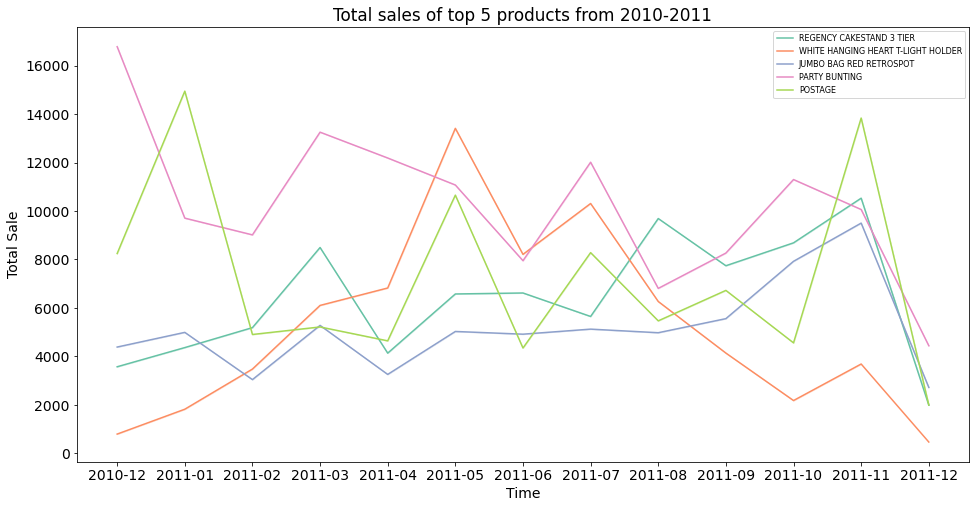

In [160]:
print('Top 5 products:', top_5_products_in_2010_2011)

product_infos_top_5 = product_infos[product_infos['product'].isin(top_5_products_in_2010_2011)]

sns.lineplot(x="year_month", y="total_sale",
             hue="product",
             palette="Set2",
             data=product_infos_top_5)

plt.xlabel("Time")
plt.ylabel("Total Sale")
plt.title("Total sales of top 5 products from 2010-2011")
plt.legend([product_classes[i] for i in top_5_products_in_2010_2011], 
           loc='upper right', 
           prop={'size': 8})

In [136]:
product_infos_top_5['unitprice'].max()

8142.75

Top 5 products: [2780, 3716, 1771, 2355, 2624]


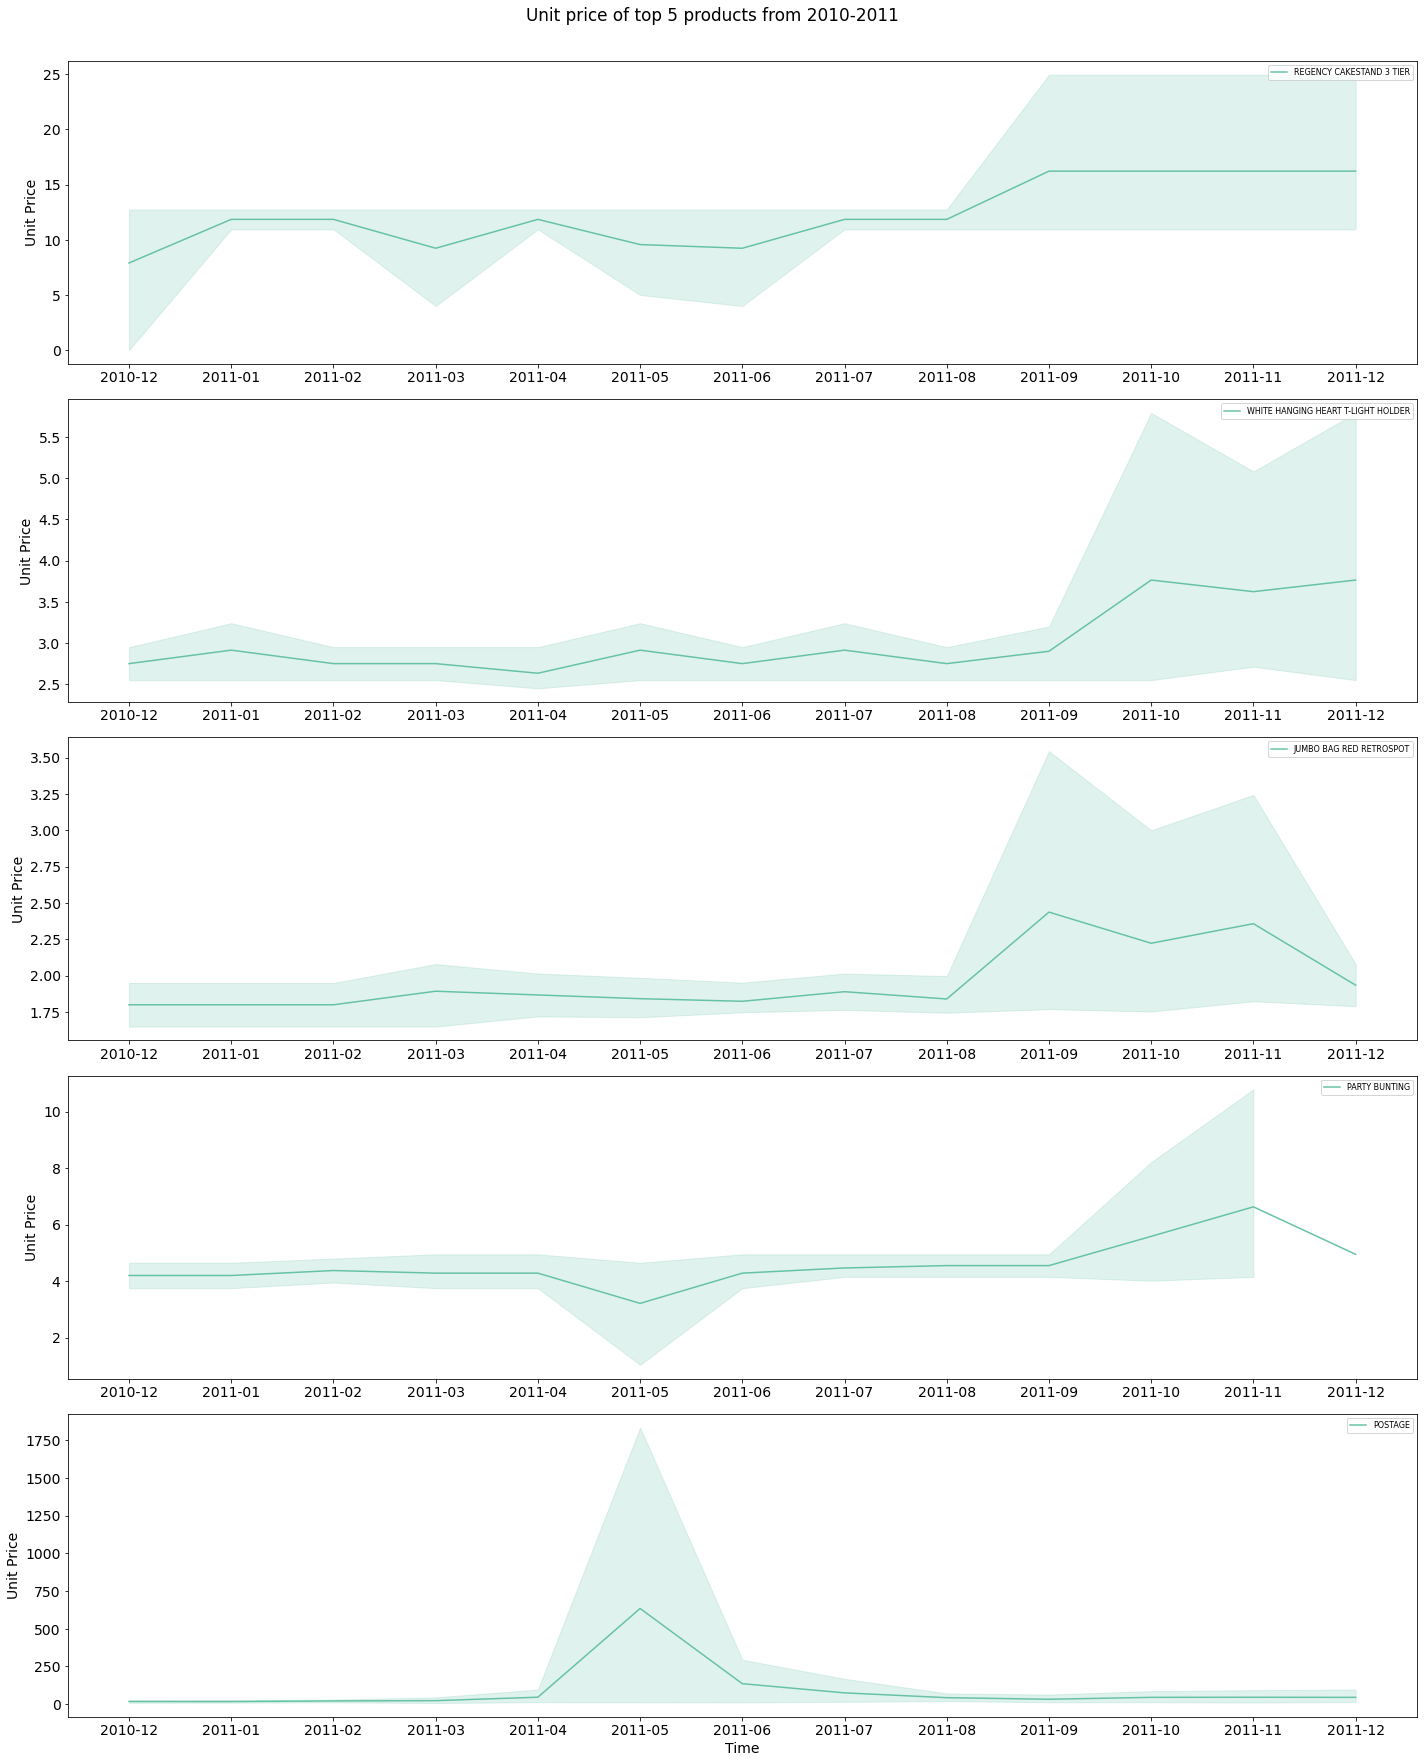

In [175]:
print('Top 5 products:', top_5_products_in_2010_2011)

fig, ax =plt.subplots(5,1, figsize=(20,25))

fig.suptitle("Unit price of top 5 products from 2010-2011")
for i in range(5):
    product_infos_top_5 = product_infos[product_infos['product'].isin([top_5_products_in_2010_2011[i]])]
    sns.lineplot(x="year_month", y="unitprice",
                 hue="product",
                 palette="Set2",
                 data=product_infos_top_5, ax=ax[i])
    
    ax[i].set_ylabel("Unit Price")
    if i+1 == 5:
        ax[i].set_xlabel("Time")
    else:
        ax[i].set_xlabel("")
    
    ax[i].legend([product_classes[top_5_products_in_2010_2011[i]]], 
               loc='upper right', 
               prop={'size': 8})

fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

In [16]:
# estimate the model and save it as lm (linear model)
lm = ols("quantity ~ month + year", data=df).fit()

In [17]:
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:               quantity   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.263
Date:                Thu, 16 Jun 2022   Prob (F-statistic):              0.283
Time:                        16:13:35   Log-Likelihood:            -2.8214e+06
No. Observations:              406829   AIC:                         5.643e+06
Df Residuals:                  406826   BIC:                         5.643e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.9432      2.021      6.404      0.0

In [ ]:
fig = sm.graphics.influence_plot(lm, criterion="cooks")
fig.tight_layout(pad=1.0)